In [46]:
import pandas as pd 
import numpy as np 
import ast 
import matplotlib.pyplot as plt
import random
import seaborn as sns
import squarify
from sklearn.metrics import r2_score
from fancyimpute import IterativeImputer
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif


## Data Cleaning / Visulization 


In [3]:
df_credit = pd.read_csv('credits.csv')
df_credit.head()



,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
df_moviesmeta = pd.read_csv('movies_metadata.csv')
df_moviesmeta.isnull().sum()

/var/folders/dg/lwzdmjjn33gcy0ydj194xr7r0000gn/T/ipykernel_50948/209593908.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_moviesmeta = pd.read_csv('movies_metadata.csv')


adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [5]:
# remove columns 
# no use of these columns
df_moviesmeta1 = df_moviesmeta.drop(['homepage','original_title','spoken_languages','overview','poster_path','tagline','imdb_id'],axis=1)



In [6]:
df_moviesmeta1['budget'] = pd.to_numeric(df_moviesmeta['budget'],errors='coerce',downcast='float')

df_moviesmeta1['popularity'] = pd.to_numeric(df_moviesmeta['popularity'],errors='coerce',downcast='float')
# converting the values in the 'budget' column to a numeric data type
# errors='coerce' parameter ensures that any non-convertible values are handled as missing values (NaN)

In [7]:
# too much missing value can't remove it
df_moviesmeta1['belongs_to_collection'] = df_moviesmeta1['belongs_to_collection'].fillna('None')
df_moviesmeta1['belongs_to_collection'] = df_moviesmeta1['belongs_to_collection'].map(lambda x: 0 if x == 'None' else 1)
# This line maps the values in the 'belongs_to_collection' column using a lambda function.
#The lambda function checks if each value is equal to the string 'None'. If it is, it assigns the value 0; otherwise, it assigns the value 1.

df_moviesmeta1['adult'] = df_moviesmeta['adult'].fillna('None')
df_moviesmeta1['adult'] = df_moviesmeta['adult'].map(lambda x: 0 if x == 'False' else 1)
# change true or false into zero and one 

In [8]:
df_moviesmeta1['id'] = pd.to_numeric(df_moviesmeta['id'],errors='coerce',downcast='float')
# This line converts the 'id' column in the DataFrame df_moviesmeta to numeric format using pd.to_numeric
# errors='coerce' argument is used to handle any errors that may occur during the conversion by replacing them with missing values (NaN).
# downcast='float' argument specifies that the resulting numeric values should be downcasted to the float data type if possible to save memory.


In [9]:
#  replaces the missing values in the 'status' column with the mode (most frequent value) of that column.
df_moviesmeta1['status'].fillna(df_moviesmeta1['status'].mode()[0],inplace=True)


In [10]:
df_moviesmeta1['release_date'] = pd.to_datetime(df_moviesmeta1['release_date'],errors='coerce')
# converts the 'release_date' column in the DataFrame df_moviesmeta1 to datetime format using pd.to_datetime
df_moviesmeta1.dropna(subset = ['release_date'],axis=0,inplace=True)
# this line drops rows from the DataFrame df_moviesmeta1 where the 'release_date' column contains missing values
# axis = 0 indicate that rows should be drop 
# inplace=True argument modifies the DataFrame df_moviesmeta1 directly without creating a new DataFrame
df_moviesmeta1['release_year'] = df_moviesmeta1['release_date'].dt.year
# This line creates a new column called 'release_year' in the DataFrame df_moviesmeta1 by extracting the year component from the 'release_date' column using the dt.year attribute.

In [11]:
df_moviesmeta1 = df_moviesmeta1.dropna(subset=['original_language'])
df_moviesmeta1 = df_moviesmeta1.dropna(subset=['video'])
# less missing value remove it directly 


In [12]:
# replace runtime missing value with mean value 
df_moviesmeta1 = df_moviesmeta1.fillna(value = df_moviesmeta1['runtime'].mean())


In [13]:
df_moviesmeta1['video'] = df_moviesmeta1['video'].map(lambda x: 0 if x == 'False' else 1)


In [14]:
# special list that looks like text but holds more information inside it, like a secret code. The json_to_list function helps us crack that secret code.
# it looks carefully at each item inside the secret code and finds the specific information we asked for (the want)
def json_to_list(row,want='name'):
    new_list = ast.literal_eval(row)    
    if new_list == [] or isinstance(new_list,float):
        return (np.nan)
    else:
        inner = []
        for j in new_list:
            inner.append(j[want])
        return (inner)

# If the code is empty or not a valid code, it says it doesn't have any information (NaN)
# isinstance(new_list,float) == checks whether the object belongs to the specified class or is an instance of the specified type
df_moviesmeta1[['production_companies']] = df_moviesmeta1[['production_companies']].applymap(json_to_list)
df_moviesmeta1[['production_countries']] = df_moviesmeta1[['production_countries']].applymap(lambda row: json_to_list(row ,'iso_3166_1'))
df_moviesmeta1[['genres']] = df_moviesmeta1[['genres']].applymap(json_to_list)

# this code tells use that we select a column called production companies from the dataframe.
# We apply the function json to list that we created above, and extract the name of the production companies. 
# Then we use the function 'applymap' to ensure that the function json to list is applied to every value in the column. 

# The 'iso_3166_1' is a code that tells the json_to_list function to specifically extract the ISO codes of the countries from the special list.
# the code takes the special lists of countries in the "production_countries" column of the movies4 table and replaces them with just the ISO codes of the countries.


In [15]:
# Count Budget, revenue that is zero
budget_zero_count = (df_moviesmeta1['budget'] == 0).sum()
print("Number of zeros in the 'budget' column:", budget_zero_count)

revenue_zero_count = (df_moviesmeta1['revenue'] == 0).sum()
print("Number of zeros in the 'revenue' column:", revenue_zero_count)

# replace the value to zero
df_moviesmeta1['budget'] = df_moviesmeta1['budget'].replace(0,np.nan)
df_moviesmeta1['revenue'] = df_moviesmeta1['revenue'].replace(0,np.nan)

Number of zeros in the 'budget' column: 36479
Number of zeros in the 'revenue' column: 37958


In [16]:
def scale_money(num):
    if num < 100:
        return num * 1000000
    elif num >= 100 and num < 1000:
        return num * 10000
    elif num >= 1000 and num < 10000:
        return num *100
    else:
        return num
    
df_moviesmeta1[['budget', 'revenue']] = df_moviesmeta1[['budget', 'revenue']].applymap(scale_money)

In [17]:
def get_all_items(df , col):
    all_items = {}
    # create an exmpty dictionary 
    for row in df[col]:
        counter = 0
        if row == np.nan or isinstance(row,float) :
            continue
# If the row is empty or has a missing value, we skip it and move to the next row. 
# If either of these conditions is true, it means that the value of row is either missing or undefined, and the code inside the if statement is skipped using the continue statement.
        for single_value in row:
# For each valid row, we look at each item one by one.
            value = all_items.get(single_value)
# For each row, we look inside our box (all_items) to see if we already have a count for that fruit. 
            if value == None:
                all_items[single_value] = counter + 1
# If we don't, it means we haven't seen it before, so we add it to the box and set the count to 1.
            else:
                all_items[single_value] = value + 1
    return all_items
#In summary, the code helps us count how many times each item appears in a specific column of a table. It looks at each row, skips empty or missing values, counts each item separately, and stores the counts in a box (all_items).
all_genres = get_all_items(df_moviesmeta1 , 'genres')
# looks at each row in the 'genres' column and counts how many times each genre appears. It returns a box with the counts of each genre.
all_companies = get_all_items(df_moviesmeta1,'production_companies')
# counts how many times each production company appears
major_prod_company = {k:v for (k,v) in all_companies.items() if v > 50}
#  We look at each production company and its count from the previous step (stored in the all_companies box). If a production company has a count greater than 50, we keep it in the major_prod_company box.

all_countries = get_all_items(df_moviesmeta1,'production_countries')
# counts how many times each production countries appears


## Horizontal bar chart representation for movie genres

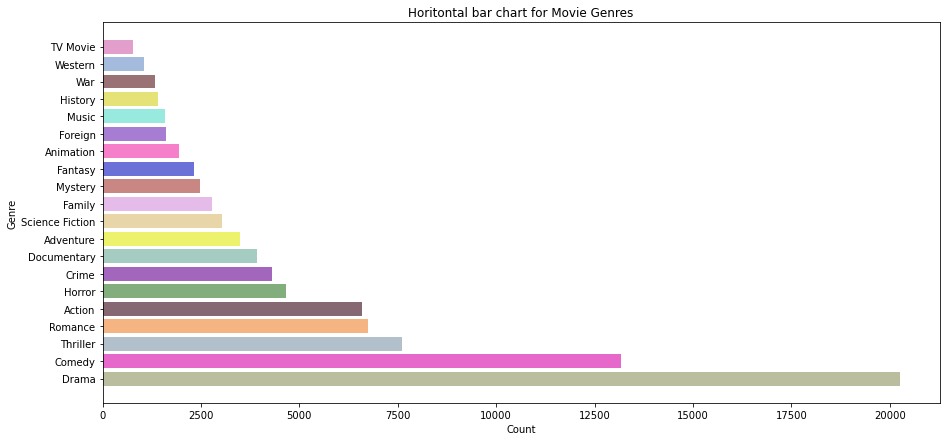

In [18]:
# horizontal bar chart for movie genres 
genres = list(all_genres.keys())
#  creates a list called genres by extracting the keys from the dictionary all_genres
counts = list(all_genres.values())
# creates a list called counts by extracting the values from the dictionary all_genres

# Sort genres and counts in descending order based on counts
genres, counts = zip(*sorted(zip(genres, counts), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(15, 7))
colors = [random.choice(['#'+format(random.randint(0, 16777215), '06x') for _ in range(6)]) for _ in genres]
# this code creates a list of colors, where each color is randomly chosen from a wide range of possibilities. These colors will be used to represent different genres.
plt.barh(genres, counts, color=colors,alpha = 0.6)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Horitontal bar chart for Movie Genres')

# Display the chart
plt.show()



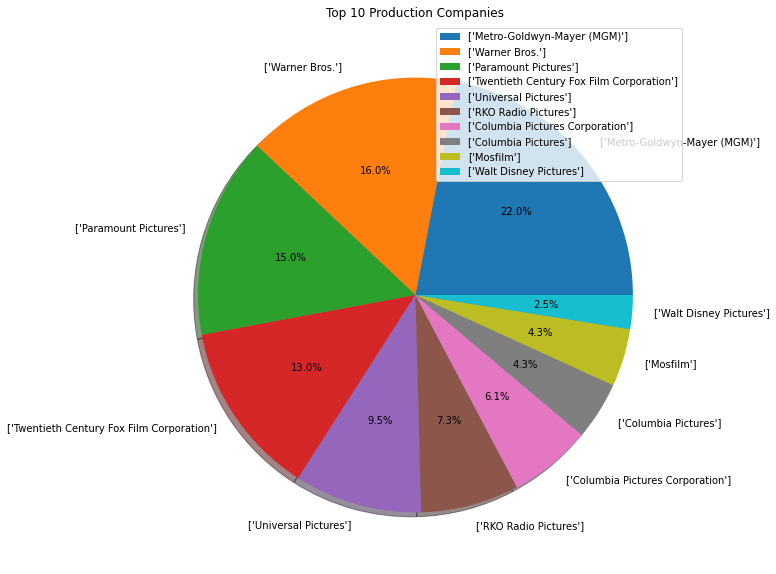

In [19]:
# Since there is too many companies, I only list out the top 10 production companies in a pie chart. 
top_10_counts = df_moviesmeta1['production_companies'].value_counts(normalize=True).head(10)
# Create a figure with a specific size
plt.figure(figsize=(13, 10))
# Create the pie chartx
pie = plt.pie(top_10_counts,labels=top_10_counts.index, autopct='%1.1f%%', shadow=True)
# Add a title to the chart
plt.title('Top 10 Production Companies')
plt.legend()
plt.show()



In [20]:
# dealing missing value for major production countries 
# Too much missing value for production countries 

choices = ['Twentieth Century Fox Film Corporation',
           'Metro-Goldwyn-Mayer (MGM)',
           'Paramount Pictures',
           'Columbia Pictures']

df_moviesmeta1['production_companies'].fillna(random.choice(choices), inplace=True)
# this code ensures that any missing values in the 'production_companies' column are filled with random top 4 production company names from the provided choices.


## Top 20 years that movie release the most based on the data

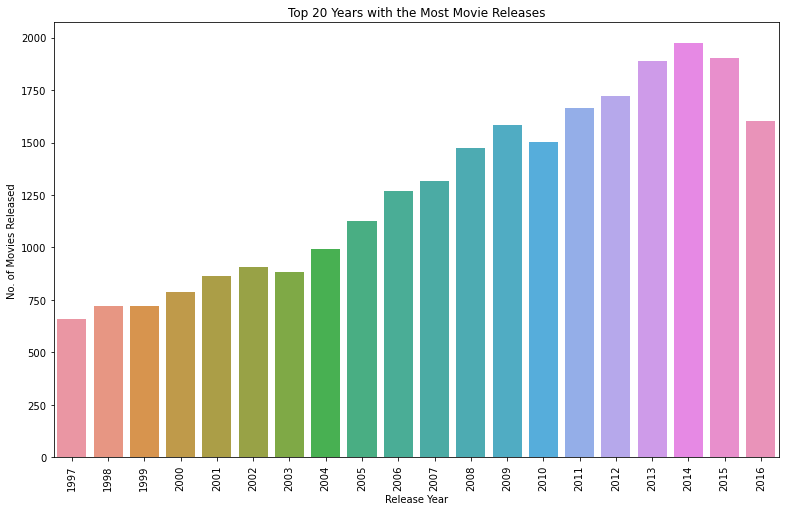

In [21]:

year_name = df_moviesmeta1['release_year'].value_counts().index.tolist()[:20]
year_count = df_moviesmeta1['release_year'].value_counts().tolist()[:20]

fig = plt.figure(figsize=(13, 8))
sns.barplot(x=year_name, y=year_count, alpha = 1.0)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel('Release Year')
plt.ylabel('No. of Movies Released')
plt.title('Top 20 Years with the Most Movie Releases')
plt.show()


## No. movies that made in top 10 languages 

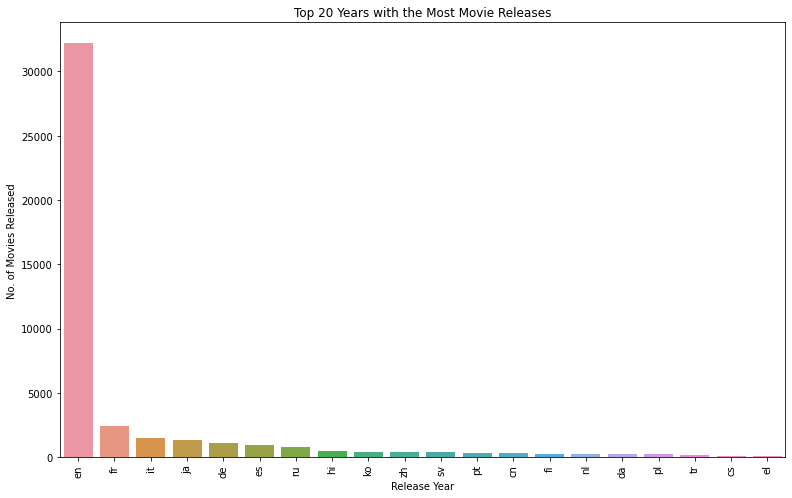

In [22]:
language_name = df_moviesmeta1['original_language'].value_counts().index.tolist()[:20]
language_count = df_moviesmeta1['original_language'].value_counts().tolist()[:20]
fig = plt.figure(figsize=(13, 8))
sns.barplot(x=language_name, y=language_count, alpha = 1.0)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel('Release Year')
plt.ylabel('No. of Movies Released')
plt.title('Top 20 Years with the Most Movie Releases')
plt.show()

## Top 10 major language in movies

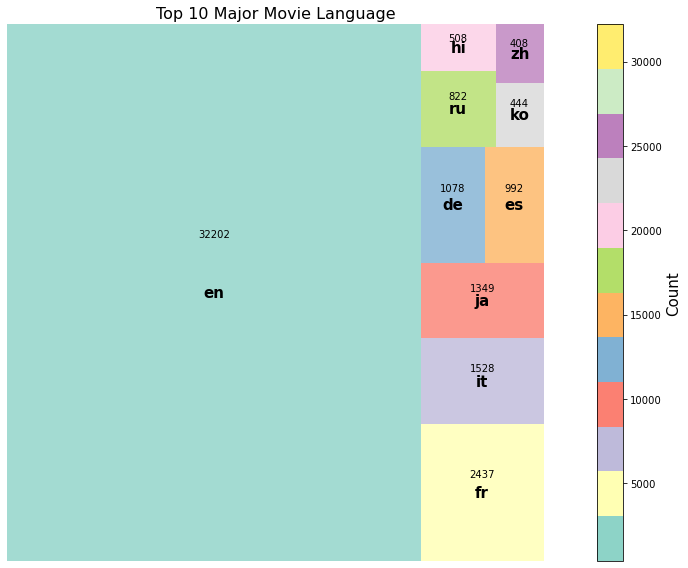

In [23]:
Countries_name = df_moviesmeta1['original_language'].value_counts().index.tolist()[:10]
Countries_count = df_moviesmeta1['original_language'].value_counts().tolist()[:10]
num_countries = len(Countries_name)
# returns the length or the number of elements in a list.
color_palette = sns.color_palette('Set3', num_countries)
# this line creates a color palette using the seaborn library (sns). The color palette is chosen from the 'Set3' set of colors. 
colors = color_palette[:num_countries]
#  selects a subset of colors from the color palette.
# In summary, these lines of code calculate the number of countries and create a color palette with a matching number of colors.

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, aspect="equal")
# add_subplot() method is used to add a subplot. 

# Generate the treemap
squarify.plot(sizes=Countries_count, label=Countries_name, color=colors, alpha=0.8, text_kwargs={'fontsize': 15, 'fontweight': 'bold'}, ax=ax)

# Add labels and title
plt.title('Top 10 Major Movie Language', fontsize=16)
plt.axis('off')

# Add data labels
for i, (label, rect) in enumerate(zip(Countries_name, ax.patches)):
    x, y = rect.get_x(), rect.get_y()
    width, height = rect.get_width(), rect.get_height()
    plt.text(x + width / 2, y + 0.6 * height, f"{Countries_count[i]}", fontsize=10, ha='center', va='bottom')
#  y + 0.6 * height == adjust the location of the text 
# Add a color bar
sm = plt.cm.ScalarMappable(cmap='Set3', norm=plt.Normalize(vmin=min(Countries_count), vmax=max(Countries_count)))
cbar = plt.colorbar(sm)
cbar.set_label('Count', fontsize=15)
# enhance your treemap plot by including a colorbar that provides additional information about the color mapping and the corresponding count values.
# Adjust plot spacing
plt.tight_layout()
# Show the treemap
plt.show()

In [24]:
# Randomly fill in missing value with the top 4 production countries 
choices = [['US','DE'],['GB','FR']]
df_moviesmeta1['production_countries'] = [random.choice(choices) if isinstance(x,float) else x for x in  df_moviesmeta1['production_countries']]
# if isinstance(x, float) else x: This is a conditional statement. It checks if the value x is of type float. If it is, it selects a random choice from choices
# this code goes through each value in the 'production_countries' column of the DataFrame movies4. If the value is a number (specifically, a float), it replaces it with a random choice from a given list of options. 




In [25]:
# missing values for genres
choices_genres = [[['Drama'],['Comedy'],['Thriller'],['Romance']]]
df_moviesmeta1['genres'] = [random.choice(choices) if isinstance(x,float) else x for x in  df_moviesmeta1['genres']]

## Top 30 movies with highest revenue

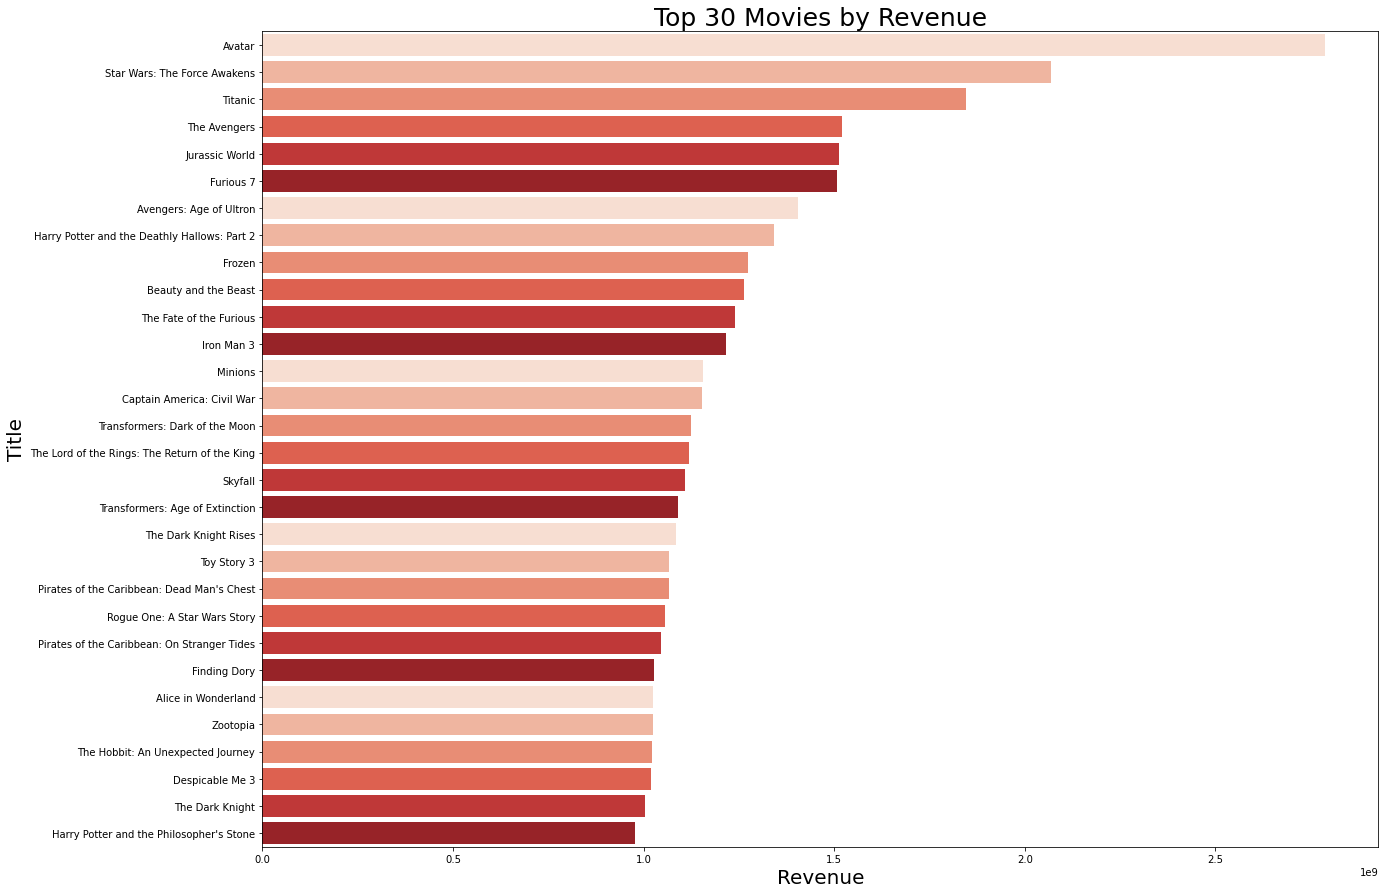

In [26]:
revenue_of_top_30 = df_moviesmeta1.sort_values(by='revenue',ascending=False)[0:30][['title','revenue','release_year']]

plt.figure(figsize=(20,15))
sns.barplot(y=revenue_of_top_30['title'],x=revenue_of_top_30['revenue'], palette = sns.color_palette("Reds"))
plt.xlabel('revenue(millions)')
plt.title('Top 30 movies with highest revenue')
plt.title("Top 30 Movies by Revenue", fontsize=25)
plt.xlabel("Revenue", fontsize=20)
plt.ylabel("Title", fontsize=20)
plt.show()


## Top 30 movies with highest budget

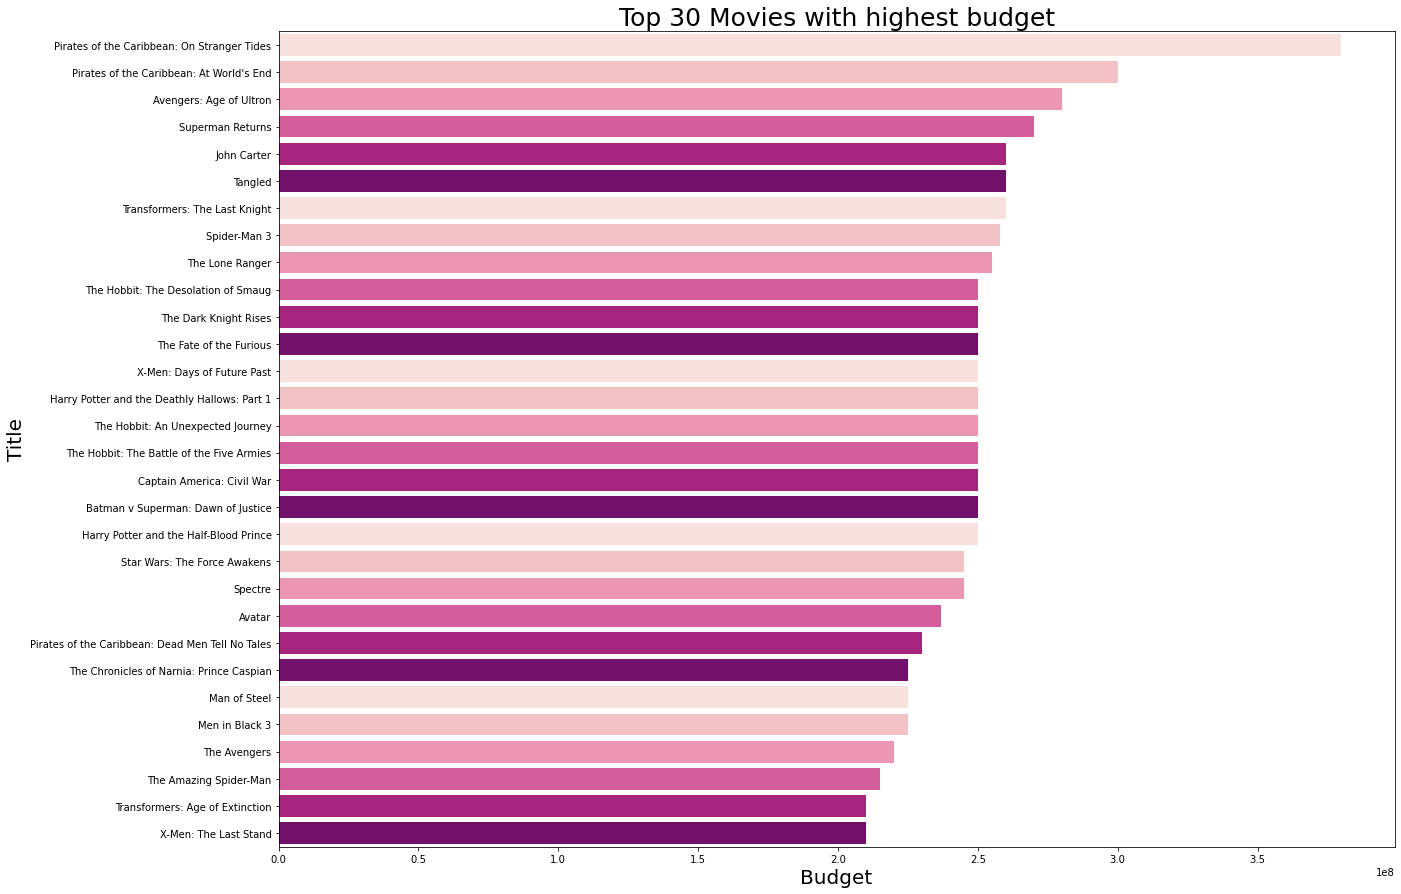

In [27]:
budget_of_top_30 = df_moviesmeta1.sort_values(by='budget',ascending=False)[0:30][['title','budget','release_year']]
plt.figure(figsize=(20,15))
sns.barplot(y=budget_of_top_30['title'],x=budget_of_top_30['budget'], palette = sns.color_palette("RdPu"))
plt.xlabel('revenue(millions)')

plt.title("Top 30 Movies with highest budget", fontsize=25)
plt.xlabel("Budget", fontsize=20)
plt.ylabel("Title", fontsize=20)
plt.show()


Too much missing value for budget and revenue so we are going to use mice method
Identify the columns in your dataset that have missing values. Let's say you have two columns: 'budget' and 'revenue' with missing values.

MICE takes an iterative approach to imputation. It starts by creating a temporary copy of the dataset and initializes the missing values with some initial estimates (e.g., mean, median, or random values).
MICE then goes through each column with missing values one by one. For each column, it treats the missing values as the target variable and the other columns as predictors.
It builds a regression model using the observed values in the dataset for that column. This model is used to predict the missing values in that column based on the observed values in the other columns.
The predicted values are then used to fill in the missing values in that column in the temporary copy of the dataset.
Steps 3-5 are repeated for each column with missing values, taking into account the updated values in the previous imputed columns.
The process of imputing missing values in each column is repeated for several iterations until convergence is reached (i.e., the imputed values stabilize).
Finally, the imputed values are used to replace the missing values in the original dataset.

## MICE method for revenue and budget  

In [28]:
# creates an instance of the IterativeImputer class, which is a tool for performing the MICE imputation method.
imputer = IterativeImputer()
# Select the columns with missing values to impute
columns_with_missing_values = ['budget', 'revenue']
# Perform MICE imputation
imputed_data = imputer.fit_transform(df_moviesmeta1[columns_with_missing_values])
# Replace the imputed values in the original dataframe
df_moviesmeta1[columns_with_missing_values] = imputed_data


## One Hot encoding 

In [29]:
df_moviesmeta1 = df_moviesmeta1.explode('genres')
df_moviesmeta1 = df_moviesmeta1.explode('original_language')
df_moviesmeta1 = df_moviesmeta1.explode('production_companies')
df_moviesmeta1 = df_moviesmeta1.explode('production_countries')
df_moviesmeta1= df_moviesmeta1.reset_index(drop=True)
df_encoded = pd.get_dummies(df_moviesmeta1)

In [35]:
df_encoded['revenue'] = df_encoded['revenue'].loc[df_encoded['revenue'].shift() != df_encoded['revenue']]
df_encoded.dropna(subset=['revenue'], inplace=True)

In [38]:
new_encoded = df_encoded


## check collinearity

                budget  popularity   revenue   runtime  vote_average  \
budget        1.000000    0.345728  0.769545  0.140159      0.050385   
popularity    0.345728    1.000000  0.447166  0.132519      0.167539   
revenue       0.769545    0.447166  1.000000  0.128620      0.095201   
runtime       0.140159    0.132519  0.128620  1.000000      0.226081   
vote_average  0.050385    0.167539  0.095201  0.226081      1.000000   
vote_count    0.600989    0.542986  0.756858  0.152998      0.184478   

              vote_count  
budget          0.600989  
popularity      0.542986  
revenue         0.756858  
runtime         0.152998  
vote_average    0.184478  
vote_count      1.000000  


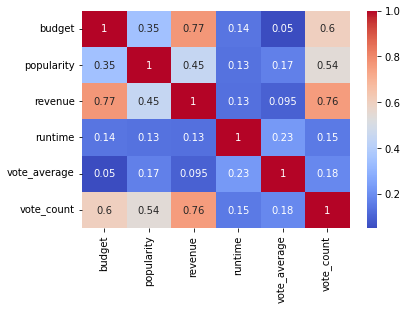

In [45]:
# 
correlation_matrix = new_encoded[['budget', 'popularity', 'revenue','runtime','vote_average','vote_count']].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Alternatively, you can print the correlation matrix
print(correlation_matrix)